This is needed to reload modules without restarting the kernel

In [1]:
%load_ext autoreload
%autoreload 2

This is needed to add eda_tools from the directories above

In [2]:
import os
os.sys.path.append('../../')

# Trying to use a Support Vector Machine Classifier for reweighting

Lets see if SVM/SVC are suitable for reweighting

https://scikit-learn.org/stable/modules/svm.html

In [3]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn import svm

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import keras.backend as K
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Dense, Dropout, Input
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from tensorflow.keras.layers import  BatchNormalization


In [6]:
f = uproot.open('/mnt/storage/lborgna/NNT/data17_with_weights.root')

In [7]:
f.keys()

[b'validation;1',
 b'control;1',
 b'sig;1',
 b'fullmassplane;1',
 b'NN_norm_bstrap_med_17;1',
 b'NN_norm_bstrap_IQR_17;1',
 b'NN_norm_bstrap_perc_25_17;1',
 b'NN_norm_bstrap_perc_75_17;1',
 b'NN_norm_VRderiv_bstrap_med_17;1',
 b'NN_norm_VRderiv_bstrap_IQR_17;1',
 b'NN_norm_VRderiv_bstrap_perc_25_17;1',
 b'NN_norm_VRderiv_bstrap_perc_75_17;1']

In [8]:
df_cr = f['control'].pandas.df()

In [9]:
df_cr.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1',
       'pairing_score_2', 'lead_jet_pT', 'lead_jet_tag', 'HT', 'm_hh_cor',
       'm_hh', 'pt_hh', 'dEta_hh', 'X_wt', 'X_wt_2', 'trig_bucket', 'm_h1',
       'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2', 'E_h2', 'pT_h2', 'eta_h2',
       'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1', 'eta_h1_j1', 'phi_h1_j1',
       'tag_h1_j1', 'quantile_h1_j1', 'angle_h1_j1', 'm_h1_j2', 'E_h1_j2',
       'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2', 'quantile_h1_j2',
       'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1',
       'phi_h2_j1', 'tag_h2_j1', 'quantile_h2_j1', 'angle_h2_j1', 'm_h2_j2',
       'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2',
       'quantile_h2_j2', 'angle_h2_j2', 'pT_4', 'pT_2', 'eta_i', 'dRjj_1',
       'dRjj_2', 'NN_d24_weight_bstrap_med_17',
       'NN_d24_weight_bstrap_perc_25_17', 'NN_d24_weight_bstrap_perc_75

In [10]:
from eda_tools.NN_RW import nominal, louppe_loss, log_inputs, create_labels, NN

Using TensorFlow backend.


In [11]:
features_to_rw = nominal()

In [12]:
features_to_rw

{'rw_cols_to_log': ['pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'X_wt'],
 'rw_cols_log': ['pT_2_log',
  'pT_4_log',
  'eta_i',
  'dRjj_1_log',
  'dRjj_2_log',
  'njets',
  'pt_hh_log',
  'X_wt_log',
  'dR_hh',
  'dPhi_h1',
  'dPhi_h2']}

In [13]:
from eda_tools.utilities import calculatedPhi, calculatedRhh

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [14]:
calculatedPhi(df_cr)
calculatedRhh(df_cr)

In [15]:
log_inputs(df_cr, to_log=features_to_rw['rw_cols_to_log'])

In [16]:
train_size = df_cr.shape[0]

In [21]:
original = df_cr.loc[df_cr['ntag'] == 2, features_to_rw['rw_cols_log']]

In [22]:
rw_cols = features_to_rw['rw_cols_log']

In [23]:
target = df_cr.loc[df_cr['ntag']>=4, features_to_rw['rw_cols_log']]

In [24]:
X_all = pd.concat((original, target), ignore_index=True).values
Y_all = create_labels(original, target)

In [25]:
Y_all = Y_all.astype('float32')

In [26]:
scaler = StandardScaler()

In [27]:
X_train = scaler.fit_transform(X_all)
Y_train = Y_all.copy()

In [28]:
idx = np.random.permutation(X_train.shape[0])

In [29]:
X_train = X_train[idx]
Y_train = Y_train[idx]

In [30]:
help(svm.SVC)

Help on class SVC in module sklearn.svm._classes:

class SVC(sklearn.svm._base.BaseSVC)
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`sklearn.svm.LinearSVC` or
 |  :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  other, see the corresponding section in the narrative documentation:
 |  :ref:`svm_kernels`.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  C : float, optional (default=1.0)
 |      Regulariza

In [31]:
clf = svm.SVC(kernel='linear', probability=True, verbose = True)

In [ ]:
clf.fit(X_train, Y_train)

In [57]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_train.shape[1]),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
    ]
)

In [58]:
import tensorflow.keras.backend as K

In [59]:
def louppe_loss_tf2(y_true, y_pred):
    return (y_true * (K.sqrt(K.exp(y_pred))) + (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred))))

In [60]:
model.compile(loss=louppe_loss_tf2, metrics = ['accuracy'], optimizer='adam')

In [61]:
history = model.fit(X_train, Y_train,
                    callbacks = [
                            EarlyStopping(monitor='val_loss', patience=10, verbose=True),
                            ModelCheckpoint('model.h5', monitor='val_loss', verbose=True, save_best_only=True) ],
                            epochs=500,
                            validation_split = 0.4,
                            batch_size=8192,
                   )

Train on 1060994 samples, validate on 707330 samples
Epoch 1/500
 901120/1060994 [========================>.....] - ETA: 0s - loss: 0.3235 - accuracy: 0.0169
Epoch 00001: val_loss improved from inf to 0.24475, saving model to model.h5
1060994/1060994 [==============================] - 1s 1us/sample - loss: 0.3108 - accuracy: 0.0168 - val_loss: 0.2447 - val_accuracy: 0.0169
Epoch 2/500
 909312/1060994 [========================>.....] - ETA: 0s - loss: 0.2394 - accuracy: 0.0168
Epoch 00002: val_loss improved from 0.24475 to 0.23839, saving model to model.h5
1060994/1060994 [==============================] - 0s 0us/sample - loss: 0.2393 - accuracy: 0.0168 - val_loss: 0.2384 - val_accuracy: 0.0169
Epoch 3/500
 917504/1060994 [========================>.....] - ETA: 0s - loss: 0.2357 - accuracy: 0.0169
Epoch 00003: val_loss improved from 0.23839 to 0.23548, saving model to model.h5
1060994/1060994 [==============================] - 0s 0us/sample - loss: 0.2353 - accuracy: 0.0168 - val_loss: 

In [62]:
model.load_weights('model.h5')

In [96]:
Y_train==0

array([False, False, False, ..., False, False, False])

In [164]:
X_val = X_train[-50000:]

In [165]:
X_val.shape

(50000, 11)

In [166]:
e = shap.DeepExplainer(model, X_val)

In [144]:
X_train[39]

array([-0.92844734, -1.32772796, -0.16197046, -1.2363453 , -0.33899717,
       -0.50991007,  0.5379018 , -1.33595821, -1.17990112,  0.72479394,
        2.03851134])

In [167]:
shap_values = e.shap_values(X_val)

In [172]:
shap_values

array([[-5.36063436e-01, -1.29106006e-01, -3.88948856e-02, ...,
        -8.42410388e-02, -9.47763624e-02,  4.48586882e-02],
       [-3.31439861e-02,  4.19307807e-02,  2.89950833e-02, ...,
         1.03851434e-02,  2.36165318e-02,  2.39363754e-03],
       [ 5.05132749e-03,  6.88773737e-02,  2.27557293e-02, ...,
         9.07674162e-03,  1.00306389e-02,  5.13127146e-02],
       ...,
       [-4.76347734e-04, -1.33425677e-01,  2.90313833e-02, ...,
        -1.07814899e-02, -9.87039635e-03, -4.03198932e-02],
       [-1.12757672e-01, -9.42420750e-02, -9.07083165e-02, ...,
        -8.78011742e-02, -2.39593299e-03, -7.37252246e-02],
       [-7.15867686e-01, -4.73926390e-01,  1.19961357e-01, ...,
        -8.40933784e-02,  7.67664815e-02, -3.49462283e-02]])

In [173]:
X_train.shape

(1768324, 11)

In [174]:
len(features_to_rw['rw_cols_log'])

11

In [175]:
help(shap.summary_plot)

Help on function summary_legacy in module shap.plots._beeswarm:

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f1228362c88>, auto_size_plot=None, use_log_scale=False)
    Create a SHAP beeswarm plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names :

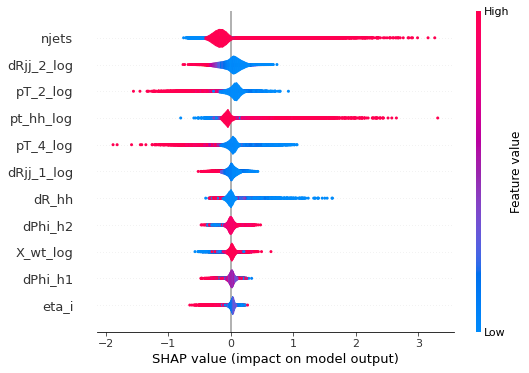

In [179]:
shap.summary_plot(
    shap_values[0], X_val,
    feature_names=features_to_rw["rw_cols_log"], plot_type="violin"
)

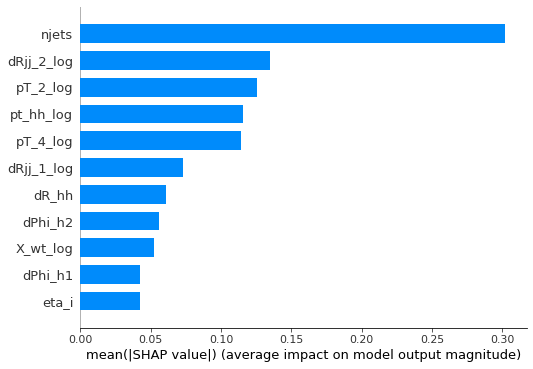

In [180]:
shap.summary_plot(
    shap_values[0], X_val,
    feature_names=features_to_rw["rw_cols_log"], plot_type="bar"
)

is the model fucked?

In [122]:
df_cr_2b = df_cr.loc[df_cr['ntag']==2]

In [123]:
pred = model.predict(scaler.transform(df_cr_2b[features_to_rw['rw_cols_log']].values), batch_size=8192)

In [124]:
df_cr_2b['NN_weight'] = np.exp(pred)[:,0]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [125]:
df_cr

run_number  event_number  mc_sf  ntag  njets  kinematic_region  \
entry                                                                     
0            326439      14652024    1.0     2      6                 2   
1            326439      11602927    1.0     2      4                 2   
2            326834    1087618060    1.0     2      5                 2   
3            326834    1697395418    1.0     2      5                 2   
4            326834    1697390982    1.0     2      5                 2   
...             ...           ...    ...   ...    ...               ...   
1790768      339957    4051406214    1.0     2      4                 2   
1790769      339957    4050716165    1.0     2      4                 2   
1790770      339957    4050478885    1.0     2      4                 2   
1790771      339957    4050925278    1.0     2      5                 2   
1790772      339957    4050762983    1.0     2      4                 2   

           m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
entry                                                              ...   
0        125.869003  380.672729         0.999066         0.008059  ...   
1         36.704128  152.690079         0.505523         0.501644  ...   
2         69.662872  237.000824         0.127664         0.063937  ...   
3        137.971207  539.372803         0.999432         0.002289  ...   
4        128.280594  471.250092         0.999404         0.003416  ...   
...             ...         ...              ...              ...  ...   
1790768  106.480461  282.510315         0.987182         0.073778  ...   
1790769   34.068737  263.774963         0.338067         0.174075  ...   
1790770  113.185013  302.098572         0.989712         0.012861  ...   
1790771  134.292450  257.755249         0.882444         0.054471  ...   
1790772  120.021294  254.511124         0.803703         0.435764  ...   

         NN_d24_weight_VRderiv_bstrap_IQR_17   dPhi_h1   dPhi_h2     dR_hh  \
entry                                                                        
0                                   0.006992  0.712290  1.113665  3.269802   
1                                   0.003047  2.735859  2.873533  2.859212   
2                                   0.005574  1.211610  1.496300  3.261541   
3                                   0.003287  0.657044  0.937919  3.052898   
4                                   0.002947  0.743185  0.861584  2.975830   
...                                      ...       ...       ...       ...   
1790768                             0.002155  1.376502  1.066973  2.992440   
1790769                             0.002147  2.019342  1.258126  2.900200   
1790770                             0.001740  0.959357  0.397834  2.971416   
1790771                             0.010816  1.011240  0.786170  2.885606   
1790772                             0.002877  1.508848  1.141601  3.208356   

         pT_2_log  pT_4_log  dRjj_1_log  dRjj_2_log  pt_hh_log  X_wt_log  
entry                                                                     
0        4.922156  4.094102    0.077623    0.150979   3.901757  1.254881  
1        4.068959  3.933927   -0.552564    0.324374   3.571677  0.877563  
2        4.276298  3.850584    0.301334    1.091012   3.377382  0.464966  
3        5.381969  4.357126   -0.239998    0.062671   4.999299  1.146898  
4        5.260033  4.285115   -0.217042   -0.146484   4.207677  1.200682  
...           ...       ...         ...         ...        ...       ...  
1790768  4.833177  4.216176    0.120126    0.466270   3.923227  1.564158  
1790769  4.190639  3.841277   -0.682192    1.167135   4.342710  0.960172  
1790770  4.620880  4.014882    0.299267    0.343568   4.373713  1.459312  
1790771  4.403122  3.976500    0.250080    0.698023   4.513000  1.284013  
1790772  4.497886  4.019805    0.421566    0.676250   1.876268  1.342464  

[1790773 rows x 84 columns]

In [126]:
df_cr_2b

run_number  event_number  mc_sf  ntag  njets  kinematic_region  \
entry                                                                     
0            326439      14652024    1.0     2      6                 2   
1            326439      11602927    1.0     2      4                 2   
2            326834    1087618060    1.0     2      5                 2   
3            326834    1697395418    1.0     2      5                 2   
4            326834    1697390982    1.0     2      5                 2   
...             ...           ...    ...   ...    ...               ...   
1790768      339957    4051406214    1.0     2      4                 2   
1790769      339957    4050716165    1.0     2      4                 2   
1790770      339957    4050478885    1.0     2      4                 2   
1790771      339957    4050925278    1.0     2      5                 2   
1790772      339957    4050762983    1.0     2      4                 2   

           m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
entry                                                              ...   
0        125.869003  380.672729         0.999066         0.008059  ...   
1         36.704128  152.690079         0.505523         0.501644  ...   
2         69.662872  237.000824         0.127664         0.063937  ...   
3        137.971207  539.372803         0.999432         0.002289  ...   
4        128.280594  471.250092         0.999404         0.003416  ...   
...             ...         ...              ...              ...  ...   
1790768  106.480461  282.510315         0.987182         0.073778  ...   
1790769   34.068737  263.774963         0.338067         0.174075  ...   
1790770  113.185013  302.098572         0.989712         0.012861  ...   
1790771  134.292450  257.755249         0.882444         0.054471  ...   
1790772  120.021294  254.511124         0.803703         0.435764  ...   

          dPhi_h1   dPhi_h2     dR_hh  pT_2_log  pT_4_log  dRjj_1_log  \
entry                                                                   
0        0.712290  1.113665  3.269802  4.922156  4.094102    0.077623   
1        2.735859  2.873533  2.859212  4.068959  3.933927   -0.552564   
2        1.211610  1.496300  3.261541  4.276298  3.850584    0.301334   
3        0.657044  0.937919  3.052898  5.381969  4.357126   -0.239998   
4        0.743185  0.861584  2.975830  5.260033  4.285115   -0.217042   
...           ...       ...       ...       ...       ...         ...   
1790768  1.376502  1.066973  2.992440  4.833177  4.216176    0.120126   
1790769  2.019342  1.258126  2.900200  4.190639  3.841277   -0.682192   
1790770  0.959357  0.397834  2.971416  4.620880  4.014882    0.299267   
1790771  1.011240  0.786170  2.885606  4.403122  3.976500    0.250080   
1790772  1.508848  1.141601  3.208356  4.497886  4.019805    0.421566   

         dRjj_2_log  pt_hh_log  X_wt_log  NN_weight  
entry                                                
0          0.150979   3.901757  1.254881   0.021189  
1          0.324374   3.571677  0.877563   0.016169  
2          1.091012   3.377382  0.464966   0.015380  
3          0.062671   4.999299  1.146898   0.008109  
4         -0.146484   4.207677  1.200682   0.006014  
...             ...        ...       ...        ...  
1790768    0.466270   3.923227  1.564158   0.007021  
1790769    1.167135   4.342710  0.960172   0.007283  
1790770    0.343568   4.373713  1.459312   0.009779  
1790771    0.698023   4.513000  1.284013   0.034945  
1790772    0.676250   1.876268  1.342464   0.009625  

[1738549 rows x 85 columns]

In [127]:
df_cr = df_cr.merge(
    df_cr_2b[["event_number", "run_number", "NN_weight"]],
    how="left",
    on=["event_number", "run_number"],
)

In [129]:
df_cr['NN_weight'].isna().value_counts()

False    1738549
True       52224
Name: NN_weight, dtype: int64

In [130]:
df_cr.fillna({'NN_weight':1}, inplace = True)

In [133]:
from eda_tools.utilities import getNorm

In [136]:
help(getNorm)

Help on function getNorm in module eda_tools.utilities:

getNorm(df, k, verbose=False, weight_column=None)
    Return the 2b -> 4b normalization in a specified kinematic region
    
    Inputs:
    - df: pandas df for data events
    - k: The kinematic region to calculate this normalization in
         * 2: SB
         * 1: CR
    - verbose: Prints out the value of 4b, 2b and ratio. Return type includes 4b and 2b values



In [138]:
muQCD = getNorm(df_cr, k=2, weight_column='NN_weight')

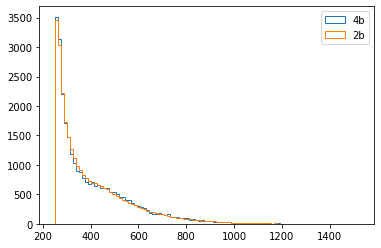

In [141]:
_,be,_ =plt.hist(df_cr.loc[df_cr.ntag>=4,'m_hh_cor'].values,
                bins = 100,
                histtype='step',
                label = '4b'
               )
_,_,_ = plt.hist(df_cr.loc[df_cr.ntag==2,'m_hh_cor'].values,
                bins = be, 
                histtype='step',
                label = '2b',
                weights=muQCD * df_cr.loc[df_cr.ntag==2,'NN_weight'].values
                )
plt.legend()

model seems to work just fine.